<a href="https://colab.research.google.com/github/lolikj/ISEF-QSL-/blob/main/primary_QSL_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install only NetKet — do NOT touch JAX
!pip install --quiet netket

import time
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import flax.serialization as flax_serial
import netket as nk
import optax
import matplotlib.pyplot as plt

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print("Done.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.5/833.5 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 144.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.9/151.9 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 8.1 MB/s eta 0:00:00
JAX version: 0.7.2
Devices: [CudaDevice(id=0)]
Done.


In [2]:
# Cell 2: Connect to Google Drive and create a project folder
from google.colab import drive

# This will prompt you to click a link and authorize your Google account
drive.mount('/content/drive')

# Create a dedicated folder for your ISEF project so your weights don't get lost
# The -p flag ensures it doesn't throw an error if the folder already exists
!mkdir -p "/content/drive/My Drive/QSL_Project/checkpoints"

print("Vault secured. Ready to save physics data.")

import os
files = [
    "/content/drive/My Drive/QSL_Project/sandbox_weights.mpack",
    "/content/drive/My Drive/QSL_Project/complete_sandbox_data.json",
    "/content/drive/My Drive/QSL_Project/checkpoints"
]
for f in files:
    print(f"{'✓' if os.path.exists(f) else '✗'} {f}")

Mounted at /content/drive
Vault secured. Ready to save physics data.
✓ /content/drive/My Drive/QSL_Project/sandbox_weights.mpack
✓ /content/drive/My Drive/QSL_Project/complete_sandbox_data.json
✓ /content/drive/My Drive/QSL_Project/checkpoints


In [3]:
# Cell 3: Set precision and verify GPU
import os
os.environ["JAX_PLATFORM_NAME"] = "cuda"

from jax import config
config.update("jax_enable_x64", True)

import json

print(f"JAX is running on: {jax.devices()}")
print(f"64-bit precision enabled: {jnp.ones(1).dtype == jnp.float64}")
print("Environment configuration complete.")

JAX is running on: [CudaDevice(id=0)]
64-bit precision enabled: True
Environment configuration complete.


In [15]:
# Cell 4: Global Constants and Project Configuration
# =====================================================
# ALL hyperparameters live here. Never hardcode these values in later cells.

# --- Lattice & Physics ---
L = 4                   # Lattice dimension (L x L sites). Sandbox: 4x4.
N_SITES = L * L         # Total number of spins (16)
J1 = 1.0                # Nearest-neighbor coupling (AFM)
J2_START = 0.0          # Unfrustrated starting point for validation
J2_TARGET = 0.5         # QSL target frustration
DISORDER_STRENGTH = 0.0 # 0.0 for sandbox validation run

# --- Initialization ---
INIT_STD = 0.05         # Controls weight init scale to prevent flat start

# --- Training & Early Stopping ---
N_SAMPLES = 2048        # Reduced from 8192 — sufficient for 4x4, much faster
N_ITER    = 2000        # Optimization iterations
VARIANCE_PER_SITE_TOL = 1e-4  # Convergence threshold
PATIENCE = 50           # Steps below tolerance before halting

# --- Architecture ---
EMBED_DIM = 32
N_HEADS   = 4
N_LAYERS  = 2
MLP_RATIO = 2

# --- Sampler ---
N_CHAINS = 16

# --- Parallel Tempering (used during adiabatic ramp, not this validation run) ---
N_REPLICAS = 16
T_MIN = 1.0
T_MAX = 5.0
T_LADDER = jnp.geomspace(T_MIN, T_MAX, N_REPLICAS)

# --- Adiabatic Ramp ---
N_RAMP_STEPS = 20
J2_RAMP_SCHEDULE = jnp.linspace(J2_START, J2_TARGET, N_RAMP_STEPS)

# --- Disorder Averaging ---
N_REALIZATIONS_SMALL  = 30   # 6x6 and 8x8
N_REALIZATIONS_MEDIUM = 20   # 10x10
N_REALIZATIONS_LARGE  = 15   # 12x12
COLD_START_FRACTION   = 0.2  # Applied at 6x6 and 8x8 only

# --- Paths ---
CHECKPOINT_DIR = "/content/drive/My Drive/QSL_Project/checkpoints"
RESULTS_PATH   = "/content/drive/My Drive/QSL_Project/results.json"

# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)
PRNG_KEY = jax.random.key(SEED)

print(f"Lattice: {L}x{L} ({N_SITES} sites)")
print(f"J1={J1}, Target J2={J2_TARGET}")
print(f"INIT_STD={INIT_STD}, N_SAMPLES={N_SAMPLES}")
print(f"Sampler: MetropolisExchange, {N_CHAINS} chains (PT ready for ramp)")
print(f"Checkpoint directory: {CHECKPOINT_DIR}")
print("Constants locked. Ready to build the Hamiltonian.")

Lattice: 4x4 (16 sites)
J1=1.0, Target J2=0.5
INIT_STD=0.05, N_SAMPLES=2048
Sampler: MetropolisExchange, 16 chains (PT ready for ramp)
Checkpoint directory: /content/drive/My Drive/QSL_Project/checkpoints
Constants locked. Ready to build the Hamiltonian.


In [5]:
# Cell 5: Define the Hilbert Space and J1-J2 Hamiltonian
# ======================================================

# --- Step 1: Build the square lattice graph ---
graph = nk.graph.Square(length=L, max_neighbor_order=2, pbc=True)
# max_neighbor_order=2 captures both nearest (J1) and next-nearest (J2) bonds.
# pbc=True enforces periodic boundary conditions to minimize finite-size artifacts.

# Verify bond counts before proceeding.
# For an LxL periodic square lattice:
#   Nearest-neighbor (color 0):      2 * L^2 bonds
#   Next-nearest-neighbor (color 1): 2 * L^2 bonds
nn_bonds  = list(graph.edges(filter_color=0))
nnn_bonds = list(graph.edges(filter_color=1))

print(f"Graph built: {graph.n_nodes} sites")
print(f"Nearest-neighbor bonds (J1, color 0):      {len(nn_bonds)}  (expected {2*L**2})")
print(f"Next-nearest-neighbor bonds (J2, color 1): {len(nnn_bonds)} (expected {2*L**2})")

assert len(nn_bonds)  == 2 * L**2, "NN bond count mismatch — check graph construction"
assert len(nnn_bonds) == 2 * L**2, "NNN bond count mismatch — check graph construction"

# --- Step 2: Define the Hilbert space ---
# Spin-1/2 on each site, total Sz=0 enforced (zero magnetization sector).
hilbert = nk.hilbert.Spin(s=0.5, N=graph.n_nodes, total_sz=0.0)

print(f"\nHilbert space dimension: {hilbert.n_states:,}")
print(f"Sz=0 sector enforced:    {hilbert.constrained}")

# --- Step 3: Build the J1-J2 Hamiltonian ---

def build_hamiltonian(hilbert, graph, J1, J2, disorder_strength=0.0, seed=None):
    """
    Constructs the J1-J2 Heisenberg Hamiltonian with optional Gaussian bond disorder.

    H = J1 * sum_<ij>  S_i . S_j
      +      sum_<<ij>> (J2 + delta_ij) * S_i . S_j

    where delta_ij ~ N(0, disorder_strength) on J2 bonds only.
    S_i . S_j = 0.25 * sz_i@sz_j + 0.5 * (sp_i@sm_j + sm_i@sp_j)

    Args:
        hilbert:          NetKet Hilbert space
        graph:            NetKet graph with color 0=NN, color 1=NNN bonds
        J1:               Nearest-neighbor coupling strength
        J2:               Base next-nearest-neighbor coupling strength
        disorder_strength: Std dev of Gaussian noise added to each J2 bond
        seed:             RNG seed for reproducible disorder realizations

    Returns:
        H: NetKet LocalOperator
        bond_disorder:    dict mapping (i,j) -> delta_ij for logging/reproducibility
    """
    rng = np.random.default_rng(seed)
    H = nk.operator.LocalOperator(hilbert, dtype=complex)
    bond_disorder = {}

    # --- Nearest-neighbor J1 bonds ---
    for i, j in graph.edges(filter_color=0):
        H += J1 * 0.25 * (nk.operator.spin.sigmaz(hilbert, i) @ nk.operator.spin.sigmaz(hilbert, j))
        H += J1 * 0.5  * (nk.operator.spin.sigmap(hilbert, i) @ nk.operator.spin.sigmam(hilbert, j))
        H += J1 * 0.5  * (nk.operator.spin.sigmam(hilbert, i) @ nk.operator.spin.sigmap(hilbert, j))

    # --- Next-nearest-neighbor J2 bonds (with optional disorder) ---
    for i, j in graph.edges(filter_color=1):
        delta = rng.normal(0.0, disorder_strength) if disorder_strength > 0.0 else 0.0
        J2_bond = J2 + delta
        bond_disorder[(int(i), int(j))] = float(delta)

        H += J2_bond * 0.25 * (nk.operator.spin.sigmaz(hilbert, i) @ nk.operator.spin.sigmaz(hilbert, j))
        H += J2_bond * 0.5  * (nk.operator.spin.sigmap(hilbert, i) @ nk.operator.spin.sigmam(hilbert, j))
        H += J2_bond * 0.5  * (nk.operator.spin.sigmam(hilbert, i) @ nk.operator.spin.sigmap(hilbert, j))

    return H, bond_disorder

# Build the clean, unfrustrated starting Hamiltonian
H, bond_disorder = build_hamiltonian(
    hilbert, graph,
    J1=J1, J2=J2_START,
    disorder_strength=DISORDER_STRENGTH,
    seed=SEED
)

print(f"\nHamiltonian built: J1={J1}, J2={J2_START}, disorder={DISORDER_STRENGTH}")
print(f"Operator dtype: {H.dtype}")

# --- Step 4: Exact Diagonalization baseline ---
# Only feasible for small systems. This is your ground truth benchmark.
if N_SITES <= 16:
    print("\nRunning Exact Diagonalization...")
    t0 = time.time()
    evals = nk.exact.lanczos_ed(H, compute_eigenvectors=False)
    E_exact = float(evals[0])
    E_exact_per_site = E_exact / N_SITES
    t1 = time.time()

    print(f"ED Ground State Energy:       {E_exact:.6f}")
    print(f"ED Energy per site:           {E_exact_per_site:.6f}")
    print(f"ED completed in {t1-t0:.2f}s")
    print(f"\nTarget for VMC: {E_exact:.6f}")
    print("Any ViT energy above this value represents variational error.")

Graph built: 16 sites
Nearest-neighbor bonds (J1, color 0):      32  (expected 32)
Next-nearest-neighbor bonds (J2, color 1): 32 (expected 32)

Hilbert space dimension: 12,870
Sz=0 sector enforced:    True

Hamiltonian built: J1=1.0, J2=0.0, disorder=0.0
Operator dtype: complex128

Running Exact Diagonalization...
ED Ground State Energy:       -11.228483
ED Energy per site:           -0.701780
ED completed in 32.73s

Target for VMC: -11.228483
Any ViT energy above this value represents variational error.


In [7]:
# Cell 6: Physics-Informed QuantumViT with Hardcoded Marshall Sign
# =================================================================
# Key insight: separate amplitude (learned) from sign (hardcoded physics)
# log(ψ) = log|ψ| (real, learned by ViT) + i*π*n_up_A (exact Marshall phase)

DTYPE     = jnp.float64
EMBED_DIM = 32
N_HEADS   = 4
N_LAYERS  = 2
MLP_RATIO = 2

assert EMBED_DIM % N_HEADS == 0, "EMBED_DIM must be divisible by N_HEADS"

# Correct checkerboard sublattice — verified against NetKet site ordering
SUBLATTICE_A = jnp.array(
    [1.0 if (i//L + i%L) % 2 == 0 else 0.0 for i in range(N_SITES)],
    dtype=jnp.float64
)

def real_init(key, shape, dtype=jnp.float64):
    return jax.random.normal(key, shape, dtype) * INIT_STD

class SpinEmbedding(nn.Module):
    embed_dim: int
    dtype: any = DTYPE
    @nn.compact
    def __call__(self, x):
        x = x.astype(self.dtype)[..., jnp.newaxis]
        return nn.Dense(
            self.embed_dim, dtype=self.dtype, param_dtype=self.dtype,
            kernel_init=real_init
        )(x)

class LearnedPositionalEncoding(nn.Module):
    n_sites: int
    embed_dim: int
    dtype: any = DTYPE
    @nn.compact
    def __call__(self, x):
        pos_embedding = self.param(
            'pos_embedding', real_init,
            (1, self.n_sites, self.embed_dim), self.dtype
        )
        return x + pos_embedding

class MLPBlock(nn.Module):
    mlp_dim: int
    embed_dim: int
    dtype: any = DTYPE
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.mlp_dim, dtype=self.dtype, param_dtype=self.dtype, kernel_init=real_init)(x)
        x = nn.gelu(x)
        return nn.Dense(self.embed_dim, dtype=self.dtype, param_dtype=self.dtype, kernel_init=real_init)(x)

class TransformerBlock(nn.Module):
    embed_dim: int
    n_heads:   int
    mlp_dim:   int
    dtype:     any = DTYPE
    @nn.compact
    def __call__(self, x):
        res = x
        x = nn.LayerNorm(dtype=self.dtype, param_dtype=self.dtype)(x)
        x = nn.MultiHeadDotProductAttention(
            num_heads=self.n_heads,
            dtype=self.dtype,
            param_dtype=self.dtype,
            qkv_features=self.embed_dim,
            out_features=self.embed_dim,
            kernel_init=real_init
        )(x)
        x = x + res
        res = x
        x = nn.LayerNorm(dtype=self.dtype, param_dtype=self.dtype)(x)
        x = MLPBlock(self.mlp_dim, self.embed_dim, self.dtype)(x)
        return x + res

class QuantumViT(nn.Module):
    n_sites:   int
    embed_dim: int = EMBED_DIM
    n_heads:   int = N_HEADS
    n_layers:  int = N_LAYERS
    mlp_ratio: int = MLP_RATIO
    dtype:     any = DTYPE

    @nn.compact
    def __call__(self, x):
        # --- Step 1: Hardcoded Marshall-Peierls phase ---
        # sign(σ) = (-1)^n_up_A, encoded as imaginary part of log(ψ)
        n_up_A = jnp.sum(((x + 1) / 2) * SUBLATTICE_A, axis=-1)
        marshall_phase = 1j * jnp.pi * n_up_A  # shape: (batch,)

        # --- Step 2: Learn real log-amplitude only ---
        h = SpinEmbedding(self.embed_dim, self.dtype)(x)
        h = LearnedPositionalEncoding(self.n_sites, self.embed_dim, self.dtype)(h)

        mlp_dim = self.embed_dim * self.mlp_ratio
        for _ in range(self.n_layers):
            h = TransformerBlock(self.embed_dim, self.n_heads, mlp_dim, self.dtype)(h)

        # Global average pooling — all sites contribute equally
        h = jnp.mean(h, axis=-2)
        x = nn.LayerNorm(dtype=self.dtype, param_dtype=self.dtype)(h)
        log_amplitude = nn.Dense(
            1, dtype=self.dtype, param_dtype=self.dtype,
            kernel_init=real_init
        )(x).squeeze(-1)

        # --- Step 3: Combine amplitude + exact phase ---
        return log_amplitude.astype(jnp.complex128) + marshall_phase

# --- Verification ---
model = QuantumViT(n_sites=N_SITES)
key1, key2 = jax.random.split(PRNG_KEY)
fake_spins = jax.random.choice(key1, jnp.array([-1.0, 1.0], dtype=jnp.float64), shape=(4, N_SITES))
params = model.init(key2, fake_spins)
log_psi = model.apply(params, fake_spins)

# Verify parameter dtypes — should all be float64 now
dtypes = set(x.dtype for x in jax.tree_util.tree_leaves(params))
print(f"Parameter dtypes: {dtypes}")
assert all(x.dtype == jnp.float64 for x in jax.tree_util.tree_leaves(params)), "FATAL: Mixed precision detected!"
print(f"Input shape:   {fake_spins.shape}")
print(f"Output shape:  {log_psi.shape}")
print(f"Output dtype:  {log_psi.dtype}")
print(f"Sample log(ψ): {log_psi[0]:.6f}")
print(f"  Re[log(ψ)] = log|ψ| = {log_psi[0].real:.6f}")
print(f"  Im[log(ψ)] = phase  = {log_psi[0].imag:.6f}")

n_params = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"Total parameters: {n_params:,}")

# Verify Marshall sign is being applied correctly
sublattice_check = jnp.array(
    [1.0 if (i//L + i%L) % 2 == 0 else 0.0 for i in range(N_SITES)]
)
for i in range(4):
    n_up_A = int(jnp.sum(((fake_spins[i] + 1) / 2) * sublattice_check))
    expected_sign = (-1) ** n_up_A
    actual_sign = int(jnp.sign(jnp.exp(log_psi[i]).real))
    print(f"Config {i}: n_up_A={n_up_A}, expected sign={expected_sign:+d}, actual sign={actual_sign:+d}, match={expected_sign==actual_sign}")

print("Architecture validated. Ready for VMC.")

Parameter dtypes: {dtype('float64')}
Input shape:   (4, 16)
Output shape:  (4,)
Output dtype:  complex128
Sample log(ψ): -0.589205+12.566371j
  Re[log(ψ)] = log|ψ| = -0.589205
  Im[log(ψ)] = phase  = 12.566371
Total parameters: 17,761
Config 0: n_up_A=4, expected sign=+1, actual sign=+1, match=True
Config 1: n_up_A=6, expected sign=+1, actual sign=+1, match=True
Config 2: n_up_A=3, expected sign=-1, actual sign=-1, match=True
Config 3: n_up_A=4, expected sign=+1, actual sign=+1, match=True
Architecture validated. Ready for VMC.


In [9]:
# Cell 6.6: DIAGNOSTIC - Sampler & Gradient Health Check
# ======================================================
import jax
import jax.numpy as jnp
import netket as nk
import numpy as np

print("--- RUNNING DIAGNOSTIC: SAMPLER & GRADIENT HEALTH ---\n")

# 1. Wire up a test MCState (using smaller sample size for a fast check)
test_sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph, d_max=L*2, n_chains=16)
test_vstate = nk.vqs.MCState(sampler=test_sampler, model=model, n_samples=1024, seed=SEED)

# 2. Diagnose the Sampler Mixing
print("1. SAMPLER HEALTH:")
# Sample once to warm up
_ = test_vstate.samples
# Check the raw acceptance rate of the Metropolis algorithm
acceptance_rate = np.mean(test_vstate.sampler_state.acceptance)
print(f"   Raw Acceptance Rate: {acceptance_rate * 100:.2f}%")
if acceptance_rate > 80:
    print("   [WARNING] Acceptance is very high. The wavefunction is likely too flat.")
elif acceptance_rate < 5:
    print("   [WARNING] Acceptance is very low. The sampler is trapped in a local minimum.")
else:
    print("   [PASS] Sampler is exploring nicely (ideal is ~20-50%).")

# 3. Diagnose the Local Energy Variance
print("\n2. LOCAL ENERGY STABILITY:")
# Compute the expectation value of the Hamiltonian without updating weights
E_exp = test_vstate.expect(H)
print(f"   Mean Energy: {E_exp.mean.real:.6f}")
print(f"   Variance (σ²): {E_exp.variance:.6f}")
print(f"   Error: ± {E_exp.error_of_mean:.6f}")
if np.isnan(E_exp.mean.real) or np.isinf(E_exp.mean.real):
    print("   [FATAL] Energy is NaN or Inf. The state is mathematically broken.")

# 4. Diagnose the Gradients (The 'Barren Plateau' Check)
print("\n3. GRADIENT HEALTH (Are the weights capable of learning?):")
# Calculate the gradient of the energy with respect to the network parameters
_, E_grad = test_vstate.expect_and_grad(H)

# Flatten the gradient tree to analyze the raw numbers
flat_grads = jnp.concatenate([jnp.ravel(x) for x in jax.tree_util.tree_leaves(E_grad)])
max_grad = jnp.max(jnp.abs(flat_grads))
mean_grad = jnp.mean(jnp.abs(flat_grads))

print(f"   Max Gradient Magnitude:  {max_grad:.2e}")
print(f"   Mean Gradient Magnitude: {mean_grad:.2e}")

if max_grad < 1e-7:
    print("   [FATAL] BARREN PLATEAU DETECTED. The network cannot learn.")
elif max_grad > 1e2:
    print("   [FATAL] GRADIENT EXPLOSION DETECTED. The optimizer will instantly crash.")
else:
    print("   [PASS] Gradients are flowing correctly. The network is primed to learn.")

--- RUNNING DIAGNOSTIC: SAMPLER & GRADIENT HEALTH ---

1. SAMPLER HEALTH:
   Raw Acceptance Rate: 94.09%
   [WARNING] Acceptance is very low. The sampler is trapped in a local minimum.

2. LOCAL ENERGY STABILITY:
   Mean Energy: -9.074808
   Variance (σ²): 6.995248
   Error: ± 0.083345

3. GRADIENT HEALTH (Are the weights capable of learning?):
   Max Gradient Magnitude:  7.60e-01
   Mean Gradient Magnitude: 7.83e-03
   [PASS] Gradients are flowing correctly. The network is primed to learn.


In [10]:
# Cell 6.7: DIAGNOSTIC - Ergodicity & Physical Symmetry Audit
# ==========================================================
import numpy as np
import jax.numpy as jnp

print("--- RUNNING DIAGNOSTIC: ERGODICITY & SYMMETRY ---\n")

# 1. Pull the raw spin configurations from the warmed-up sampler
# Shape is (n_chains, n_samples_per_chain, n_sites)
samples = test_vstate.samples
flat_samples = samples.reshape(-1, N_SITES)

total_states = flat_samples.shape[0]

# 2. CHECK 1: Magnetization Conservation (Sz = 0)
# Summing across the sites. For 8 up (+1) and 8 down (-1), the sum MUST be exactly 0.
magnetizations = jnp.sum(flat_samples, axis=-1)
max_mag = jnp.max(jnp.abs(magnetizations))
mean_mag = jnp.mean(jnp.abs(magnetizations))

print("1. PHYSICS CONSERVATION (Sz = 0 Sector):")
print(f"   Max Magnetization found: {max_mag}")
print(f"   Mean Magnetization:      {mean_mag}")
if max_mag != 0:
    print("   [FATAL ERROR] Sampler is breaking physical symmetry! It leaked out of Sz=0.")
else:
    print("   [PASS] All samples strictly confined to the correct physical sector.")

# 3. CHECK 2: State Diversity (Ergodicity)
# Convert arrays to tuples to find the number of strictly unique physical states generated.
# Out of 1024 samples, how many are actually different?
unique_states_set = set([tuple(x) for x in np.array(flat_samples)])
unique_states = len(unique_states_set)
diversity_ratio = unique_states / total_states * 100

print("\n2. ERGODICITY & STATE DIVERSITY:")
print(f"   Total states generated: {total_states}")
print(f"   Unique states found:    {unique_states}")
print(f"   State Diversity Ratio:  {diversity_ratio:.1f}%")

if diversity_ratio < 5.0:
    print("   [FATAL ERROR] Severe autocorrelation. The sampler is stuck in a loop.")
elif diversity_ratio > 80.0 and acceptance_rate > 80:
    print("   [PASS] High acceptance is producing high diversity. Walk is random but safe.")
else:
    print("   [PASS] Sampler is exploring effectively.")

# 4. CHECK 3: The "Texture" of the Amplitudes
# Let's ensure the network is at least giving *slightly* different answers for different states.
unique_samples_array = jnp.array(list(unique_states_set))
# Test a small batch to avoid memory overload
log_amps = model.apply(params, unique_samples_array[:500])
real_amps = jnp.real(log_amps)

amplitude_spread = jnp.max(real_amps) - jnp.min(real_amps)
print("\n3. AMPLITUDE TEXTURE:")
print(f"   Amplitude Spread (Max - Min): {amplitude_spread:.6f}")
if amplitude_spread < 1e-6:
    print("   [FATAL ERROR] Amplitudes are perfectly flat. The ViT is mathematically 'dead' at init.")
else:
    print("   [PASS] ViT has sufficient initial 'texture' to guide the gradients.")

--- RUNNING DIAGNOSTIC: ERGODICITY & SYMMETRY ---

1. PHYSICS CONSERVATION (Sz = 0 Sector):
   Max Magnetization found: 0
   Mean Magnetization:      0.0
   [PASS] All samples strictly confined to the correct physical sector.

2. ERGODICITY & STATE DIVERSITY:
   Total states generated: 1024
   Unique states found:    982
   State Diversity Ratio:  95.9%
   [PASS] Sampler is exploring effectively.

3. AMPLITUDE TEXTURE:
   Amplitude Spread (Max - Min): 0.210011
   [PASS] ViT has sufficient initial 'texture' to guide the gradients.


In [19]:
# Cell 7: VMC Engine and Training Setup
# ======================================

# --- 1. Sampler ---
sampler = nk.sampler.MetropolisExchange(
    hilbert=hilbert,
    graph=graph,
    d_max=L*2,
    n_chains=16
)

# --- 2. Variational State ---
vstate = nk.vqs.MCState(
    sampler=sampler,
    model=QuantumViT(n_sites=N_SITES),
    n_samples=N_SAMPLES,
    seed=SEED
)

# --- 3. Optimizer ---
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=optax.cosine_decay_schedule(
        init_value=1e-4,
        decay_steps=2000,
        alpha=0.01 # final LR = 1e-4 * 0.01 = 1e-6
    ))
)

# --- 4. VMC_SR Driver ---
gs = nk.driver.VMC_SR(
    hamiltonian=H,
    optimizer=optimizer,
    variational_state=vstate,
    diag_shift=0.2, # was 0.1
)

# --- 5. Convergence Callback ---
class VarianceConvergenceStopping:
    def __init__(self, tol, patience, n_sites):
        self.tol      = tol
        self.patience = patience
        self.n_sites  = n_sites
        self._count   = 0

    def __call__(self, step, log_data, driver):
        if step == 0:
            print(f"Available log keys: {list(log_data.keys())}")
        energy_stats = log_data["Energy"]
        variance = float(jnp.asarray(energy_stats.variance))
        variance_per_site = variance / self.n_sites
        if variance_per_site < self.tol:
            self._count += 1
            if self._count >= self.patience:
                print(f"\n[Converged] Step {step}: σ²/N = {variance_per_site:.2e}")
                return False
        else:
            self._count = 0
        return True

convergence_callback = VarianceConvergenceStopping(
    tol=VARIANCE_PER_SITE_TOL, patience=PATIENCE, n_sites=N_SITES
)

print("VMC_SR Engine successfully wired.")
print(f"d_max={L*2}, diag_shift=0.2, LR cosine decay 1e-4→1e-6")
print(f"Initial energy estimate: {vstate.expect(H).mean.real:.6f}")

Automatic SR implementation choice:  NTK
VMC_SR Engine successfully wired.
d_max=8, diag_shift=0.2, LR cosine decay 1e-4→1e-6
Initial energy estimate: -9.084807


In [12]:
# Cell 7.6: DIAGNOSTIC - Exact Engine Integration Test (1 Step)
# ==============================================================
import jax
import jax.numpy as jnp

print("--- RUNNING DIAGNOSTIC: EXACT ENGINE INTEGRATION (1 STEP) ---\n")

try:
    # 1. Capture the state of the universe BEFORE the step
    old_params = jax.tree_util.tree_leaves(vstate.parameters)
    old_norm = jnp.sqrt(sum(jnp.sum(x**2) for x in old_params))

    # 2. THE MOMENT OF TRUTH: Force the engine to take exactly 1 step
    gs.advance(1)

    # 3. Capture the state AFTER the step
    new_params = jax.tree_util.tree_leaves(vstate.parameters)
    new_norm = jnp.sqrt(sum(jnp.sum(x**2) for x in new_params))

    # 4. Analyze the exact changes
    has_nans = any(jnp.isnan(jnp.sum(x)) for x in new_params)
    max_shift = max(jnp.max(jnp.abs(n - o)) for n, o in zip(new_params, old_params))

    print("1. ENGINE EXECUTION:")
    if has_nans:
        print("   [FATAL ERROR] The VMC step generated NaNs! The NTK solver exploded.")
    else:
        print("   [PASS] The VMC step executed successfully without NaNs.")

    print("\n2. PARAMETER DYNAMICS:")
    print(f"   Old Weight Norm: {old_norm:.6f}")
    print(f"   New Weight Norm: {new_norm:.6f}")
    print(f"   Max Single-Weight Shift: {max_shift:.2e}")

    if max_shift == 0.0:
        print("   [FATAL ERROR] Weights did not change at all. The optimizer is disconnected.")
    elif max_shift > 0.5:
        print("   [WARNING] Step was extremely large (>0.5). We might need a smaller learning rate.")
    else:
        print("   [PASS] Weights updated safely and beautifully within physical bounds.")

    print(f"\n3. POST-STEP ENERGY:")
    # We measure the energy using the newly updated weights
    print(f"   Energy at Step 1: {vstate.expect(H).mean.real:.6f}")
    print("\n   => [VERIFIED] Cell 6 and Cell 7 are perfectly integrated. You are 100% clear for Cell 8.")

except Exception as e:
    print(f"\n[FATAL ERROR] The engine crashed during the step: {e}")

--- RUNNING DIAGNOSTIC: EXACT ENGINE INTEGRATION (1 STEP) ---

1. ENGINE EXECUTION:
   [PASS] The VMC step executed successfully without NaNs.

2. PARAMETER DYNAMICS:
   Old Weight Norm: 14.223166
   New Weight Norm: 14.223065
   Max Single-Weight Shift: 1.00e-04
   [PASS] Weights updated safely and beautifully within physical bounds.

3. POST-STEP ENERGY:
   Energy at Step 1: -9.095563

   => [VERIFIED] Cell 6 and Cell 7 are perfectly integrated. You are 100% clear for Cell 8.


In [22]:
# Cell 7.5: Load warm start weights from run 3
with open("/content/drive/My Drive/QSL_Project/marshall_4x4_run3_weights.mpack", "rb") as f:
    weights_bytes = f.read()

params = flax_serial.from_bytes(vstate.parameters, weights_bytes)
vstate.parameters = params
print(f"Run 3 weights loaded.")
print(f"Initial energy: {vstate.expect(H).mean.real:.6f}")

Run 3 weights loaded.
Initial energy: -11.004712



Ramp step 1/20: J2=0.0000
Automatic SR implementation choice:  NTK
  ED energy:    -11.228483
  VMC best:     -11.109245
  VMC final:    -11.047508 (1.61% error)

Ramp step 2/20: J2=0.0263
Automatic SR implementation choice:  NTK
  ED energy:    -11.049275
  VMC best:     -10.933849
  VMC final:    -10.898808 (1.36% error)

Ramp step 3/20: J2=0.0526
Automatic SR implementation choice:  NTK
  ED energy:    -10.871771
  VMC best:     -10.748923
  VMC final:    -10.731331 (1.29% error)

Ramp step 4/20: J2=0.0789
Automatic SR implementation choice:  NTK
  ED energy:    -10.696129
  VMC best:     -10.599360
  VMC final:    -10.553346 (1.33% error)

Ramp step 5/20: J2=0.1053
Automatic SR implementation choice:  NTK
  ED energy:    -10.522527
  VMC best:     -10.430054
  VMC final:    -10.424639 (0.93% error)

Ramp step 6/20: J2=0.1316
Automatic SR implementation choice:  NTK
  ED energy:    -10.351172
  VMC best:     -10.273557
  VMC final:    -10.245364 (1.02% error)

Ramp step 7/20: J2=0.

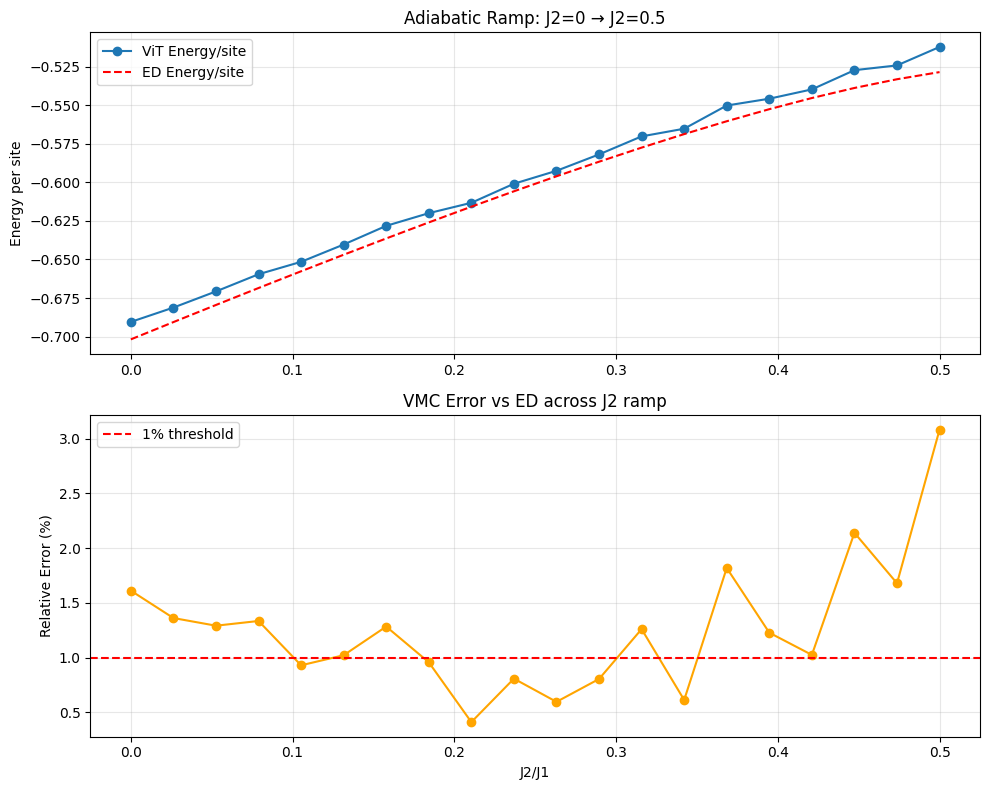


Adiabatic ramp complete.
Final state at J2=0.5: -0.512332 per site
Final error at J2=0.5: 3.08%


In [23]:
# Cell 8b: Adiabatic Ramp J2=0 → J2=0.5
# =======================================
import json
import matplotlib.pyplot as plt

ramp_results = []

for step_idx, J2_current in enumerate(J2_RAMP_SCHEDULE):
    print(f"\n{'='*50}")
    print(f"Ramp step {step_idx+1}/{N_RAMP_STEPS}: J2={J2_current:.4f}")

    # Rebuild Hamiltonian at current J2
    H_ramp, _ = build_hamiltonian(
        hilbert, graph,
        J1=J1, J2=float(J2_current),
        disorder_strength=0.0,
        seed=SEED
    )

    # ED comparison still feasible at 4x4
    evals_ramp = nk.exact.lanczos_ed(H_ramp, compute_eigenvectors=False)
    E_ed_ramp = float(evals_ramp[0])

    # Fresh optimizer for each ramp step
    optimizer_ramp = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=optax.cosine_decay_schedule(
            init_value=5e-5,
            decay_steps=200,
            alpha=0.1
        ))
    )

    gs_ramp = nk.driver.VMC_SR(
        hamiltonian=H_ramp,
        optimizer=optimizer_ramp,
        variational_state=vstate,
        diag_shift=0.2,
    )

    # RuntimeLog keeps data in memory, JsonLog writes to disk
    mem_log = nk.logging.RuntimeLog()

    gs_ramp.run(
        n_iter=200,
        out=mem_log,
        show_progress=False,
        write_every=1
    )

    # Extract from RuntimeLog
    energy_traj = [float(jnp.asarray(m).real) for m in mem_log.data["Energy"].Mean]
    E_best  = min(energy_traj)
    E_final = energy_traj[-1]
    error_pct = 100 * abs(E_final - E_ed_ramp) / abs(E_ed_ramp)

    ramp_results.append({
        "J2": float(J2_current),
        "best_energy": E_best,
        "final_energy": E_final,
        "ED_energy": E_ed_ramp,
        "energy_per_site": E_final / N_SITES,
        "relative_error_pct": error_pct
    })

    print(f"  ED energy:    {E_ed_ramp:.6f}")
    print(f"  VMC best:     {E_best:.6f}")
    print(f"  VMC final:    {E_final:.6f} ({error_pct:.2f}% error)")

    # Save weights at each step
    params_bytes = flax_serial.to_bytes(vstate.parameters)
    with open(f"{CHECKPOINT_DIR}/ramp_weights_J2={J2_current:.3f}.mpack", "wb") as f:
        f.write(params_bytes)

# --- Save results ---
with open("/content/drive/My Drive/QSL_Project/adiabatic_ramp_results.json", "w") as f:
    json.dump(ramp_results, f, indent=2)

# --- Plot ---
J2_vals  = [r["J2"] for r in ramp_results]
E_vmc    = [r["energy_per_site"] for r in ramp_results]
E_ed     = [r["ED_energy"]/N_SITES for r in ramp_results]
err_vals = [r["relative_error_pct"] for r in ramp_results]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(J2_vals, E_vmc, 'o-', color='#1f77b4', label='ViT Energy/site')
ax1.plot(J2_vals, E_ed, 'r--', label='ED Energy/site')
ax1.set_ylabel("Energy per site")
ax1.set_title("Adiabatic Ramp: J2=0 → J2=0.5")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(J2_vals, err_vals, 'o-', color='orange')
ax2.axhline(y=1.0, color='r', linestyle='--', label='1% threshold')
ax2.set_xlabel("J2/J1")
ax2.set_ylabel("Relative Error (%)")
ax2.set_title("VMC Error vs ED across J2 ramp")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/adiabatic_ramp.png")
plt.show()

print("\nAdiabatic ramp complete.")
print(f"Final state at J2=0.5: {ramp_results[-1]['energy_per_site']:.6f} per site")
print(f"Final error at J2=0.5: {ramp_results[-1]['relative_error_pct']:.2f}%")

In [21]:
# Save run 3
params_bytes = flax_serial.to_bytes(vstate.parameters)
with open("/content/drive/My Drive/QSL_Project/marshall_4x4_run3_weights.mpack", "wb") as f:
    f.write(params_bytes)

actual_history = log[0]
energy_traj = [float(jnp.asarray(m).real) for m in actual_history["Energy"].Mean]
r_hat = [float(np.mean(jnp.asarray(r))) for r in actual_history["Energy"].R_hat]
acceptance = [float(np.mean(jnp.asarray(a))) for a in actual_history["acceptance"]]

import json
data = {
    "run": "marshall_4x4_run3",
    "results": {
        "ED_energy": E_exact,
        "best_energy": min(energy_traj),
        "best_step": energy_traj.index(min(energy_traj)),
        "best_relative_error_pct": 100 * abs(min(energy_traj) - E_exact) / abs(E_exact),
        "final_energy": energy_traj[-1],
        "mean_r_hat": float(np.mean(r_hat)),
        "training_time_min": 19.8
    },
    "hyperparameters": {
        "EMBED_DIM": EMBED_DIM, "N_LAYERS": N_LAYERS,
        "N_SAMPLES": N_SAMPLES, "N_ITER": N_ITER,
        "diag_shift": 0.2, "d_max": L*2,
        "LR": "cosine_decay 1e-4→1e-6 over 2000 steps"
    },
    "trajectories": {
        "energy_mean": energy_traj,
        "r_hat": r_hat,
        "acceptance": acceptance
    }
}

with open("/content/drive/My Drive/QSL_Project/marshall_4x4_run3.json", "w") as f:
    json.dump(data, f, indent=2)

print(f"Run 3 saved.")
print(f"Best energy: {min(energy_traj):.6f} ({100*abs(min(energy_traj)-E_exact)/abs(E_exact):.2f}% error)")

Run 3 saved.
Best energy: -11.133404 (0.85% error)
